In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

In [2]:
def rawToDf(file, key):
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p -',
        '24hr' : '%d/%m/%Y, %H:%M -',
        'custom': ''
    }
    
    with open(file,'r',encoding="utf8") as raw_data:
        # converting the list split by newline char as one whole string as there can be multi-line messages
        raw_string = ' '.join(raw_data.read().split('\n')) 
        # splits at all the date-time pattern, resulting in list of all the messages with user names
        user_msg = re.split(split_formats[key],raw_string)[1:]
        # finds all the date-time patterns
        date_time = re.findall(split_formats[key],raw_string)
        
        #Exporting to dataframe
        df = pd.DataFrame({'date_time':date_time, 'user_msg':user_msg})
        
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key],errors='ignore')
    
    
    #split user and messages
    usernames = []
    msgs = []
    for i in df['user_msg']:
         # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        a = re.split('([\w\W]+?):\s', i)
        if(a[1:]): #User typed message
            usernames.append(a[1])
            msgs.append(a[2])
        else:  # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])
            
        
    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df
            

In [3]:
df = rawToDf('chats.txt', '12hr')

In [4]:
df

,date_time,user,msg
0,"10/08/19, 9:23 pm -",grp_notif,"Pruthvi PG BMSCE created group ""😎Jakka🎓Jawana'..."
1,"10/08/19, 9:23 pm -",grp_notif,You were added
2,"16/03/20, 6:49 pm -",Anant BMS,1.4k ivattu mado javabdari nandu.
3,"16/03/20, 6:49 pm -",Anant BMS,Agta ide nodu
4,"16/03/20, 6:58 pm -",Anant BMS,1.4k aytu
...,...,...,...
34919,"07/07/21, 2:38 pm -",Pradeep,We have ADA lab exam at 5
34920,"07/07/21, 2:38 pm -",Omkar PG BMSCE,Ha
34921,"07/07/21, 2:38 pm -",Omkar PG BMSCE,<Media omitted>
34922,"07/07/21, 2:38 pm -",VSM,<Media omitted>


In [5]:
me = "VSM"

### Data cleaning (omitting stickers, links and images)

In [6]:
images = df[df['msg']=="<Media omitted> "] #no. of images,stickers, images are represented by <media omitted>
images.shape

(13413, 3)

In [7]:
grp_notif = df[df['user']=="grp_notif"] #no. of grp notifications
grp_notif.shape

(141, 3)

In [8]:
df.drop(images.index, inplace=True) #removing images
df.drop(grp_notif.index, inplace=True) #removing grp_notif

In [9]:
df.reset_index(inplace=True, drop=True)
df.shape
df

,date_time,user,msg
0,"16/03/20, 6:49 pm -",Anant BMS,1.4k ivattu mado javabdari nandu.
1,"16/03/20, 6:49 pm -",Anant BMS,Agta ide nodu
2,"16/03/20, 6:58 pm -",Anant BMS,1.4k aytu
3,"16/03/20, 6:59 pm -",Anant BMS,We will make it more success once the clg star...
4,"16/03/20, 7:00 pm -",Anant BMS,Released in wrong time. Should have released a...
...,...,...,...
21365,"07/07/21, 2:37 pm -",Omkar PG BMSCE,Ha
21366,"07/07/21, 2:37 pm -",Omkar PG BMSCE,Pubg is lighter than COD now i guess
21367,"07/07/21, 2:37 pm -",VSM,@919108542860 olle phone itkondidane barode illa
21368,"07/07/21, 2:38 pm -",Pradeep,We have ADA lab exam at 5


In [10]:
users = df['user'].unique()
users

array(['Anant BMS', 'Pruthvi PG BMSCE', 'Vineet PG BMSCE', 'Nikshith',
       'Shubham PG BMSCE', 'Natesh', 'Omkar PG BMSCE', 'Pradeep', 'VSM',
       '+91 90350 84354', '+91 93806 49169', 'Vineeth',
       'Karthik Sirsi PG'], dtype=object)

## Q1:  Who is the most active member of the group. Who is the least active?

In [11]:
temp = pd.DataFrame(df.groupby("user")["msg"].count().sort_values(ascending=False))
temp

,msg
user,
Anant BMS,4474
Pruthvi PG BMSCE,3503
Vineet PG BMSCE,3497
Omkar PG BMSCE,2596
Nikshith,2312
Pradeep,1667
Vineeth,1041
VSM,874
Shubham PG BMSCE,607


In [12]:
temp = temp.reset_index()
x = temp['user']
y = temp['msg']

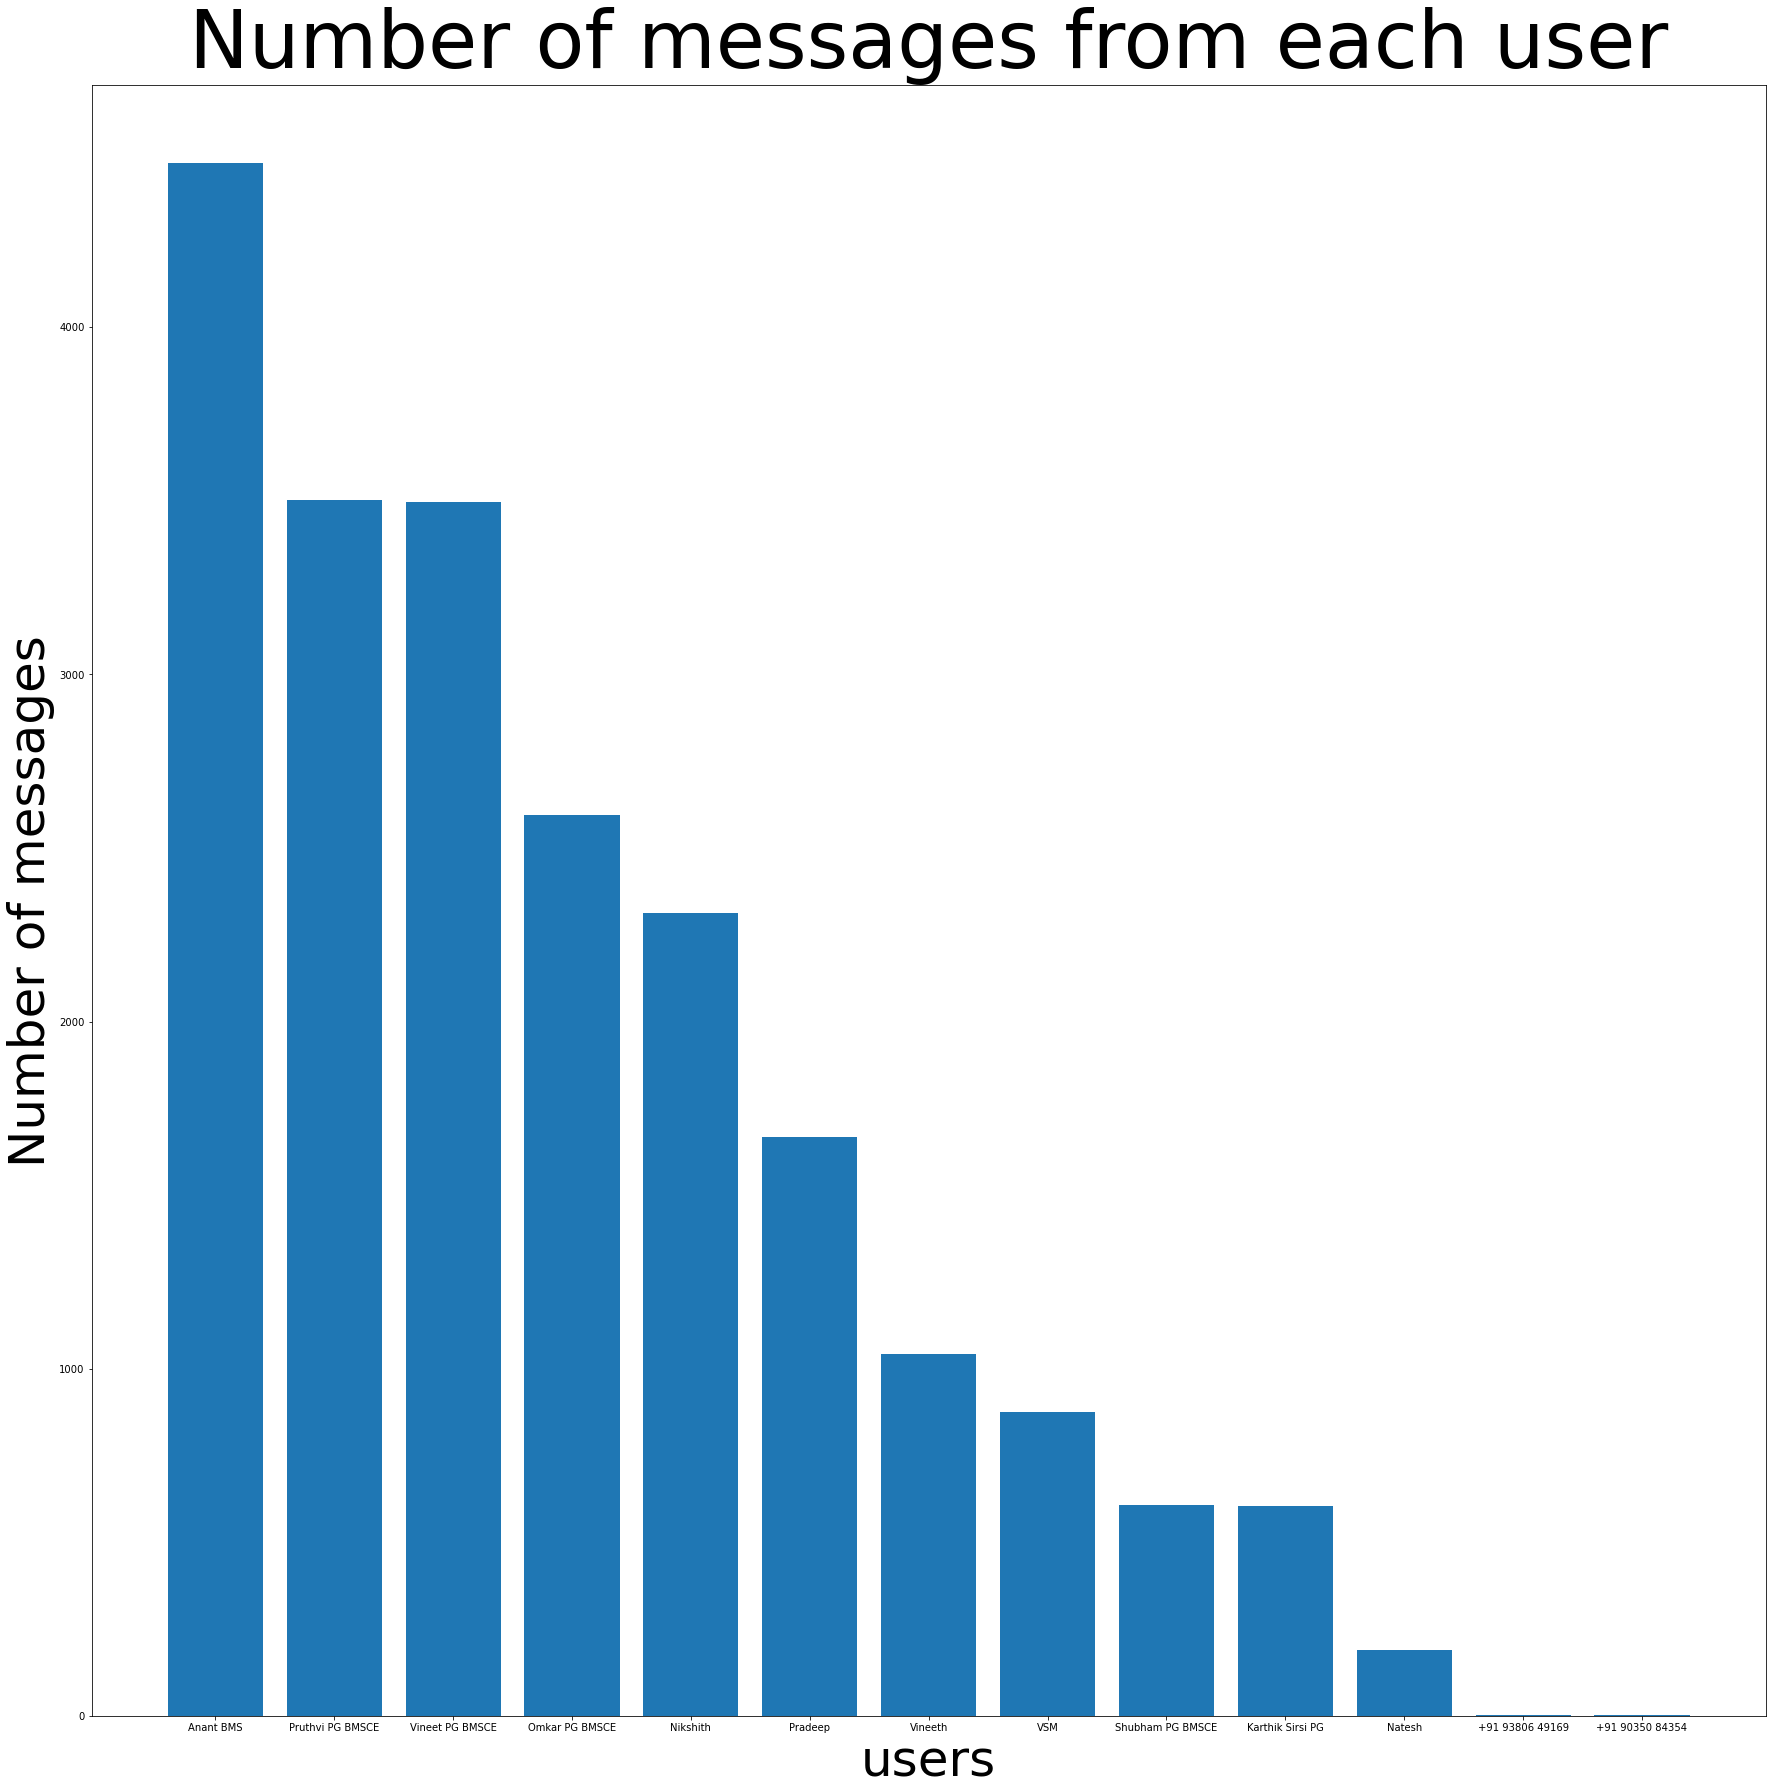

In [13]:
plt.figure(figsize=(30,30))
plt.bar(x,y,align='center') # A bar chart
plt.title('Number of messages from each user',fontsize=80)
plt.xlabel('users',fontsize=50)
plt.ylabel('Number of messages',fontsize=50)
plt.rcParams["font.size"] = "10"
plt.show()

## Q2: Most used words

In [14]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [15]:
msgs = ''
for msg in df['msg']:
    msgs = msgs + msg
msgs_word_count = word_count(msgs)
# msgs_word_count

In [16]:
msgs_word_count_df = pd.DataFrame(msgs_word_count.items())
msgs_word_count_df = msgs_word_count_df.rename(columns={0: "words", 1: "count"})
msgs_word_count_df

,words,count
0,1.4k,3
1,ivattu,2
2,mado,5
3,javabdari,1
4,nandu.,1
...,...,...
25849,madidnante,1
25850,😫😢,1
25851,squad,1
25852,lighter,1


In [17]:
#get top 20 most used words
msgs_word_count_df.sort_values(by=['count'],ascending=False).head(30)

,words,count
23922,:),1989
90,😂,840
45,to,808
279,I,800
25,is,767
16,the,731
22,in,535
102,and,503
88,of,475
161,😂😂,390


In [18]:
#count of following words
words_to_search = ['hippo','oma','praneetha','prathvi','ananta','VSM','padda','nikshith','vineeth','shubham','karthik']
required_repeated_words_df = pd.DataFrame({})
for words in words_to_search:
    required_repeated_words_df = required_repeated_words_df.append(msgs_word_count_df[msgs_word_count_df['words']==words])
required_repeated_words_df.sort_values(by=['count'],ascending=False)

,words,count
3525,prathvi,58
340,oma,54
1009,padda,32
4440,praneetha,29
3809,VSM,25
3020,nikshith,24
41,vineeth,24
381,hippo,20
15863,karthik,6
9137,shubham,5


In [19]:
words_x = required_repeated_words_df['words']
words_y = required_repeated_words_df['count']

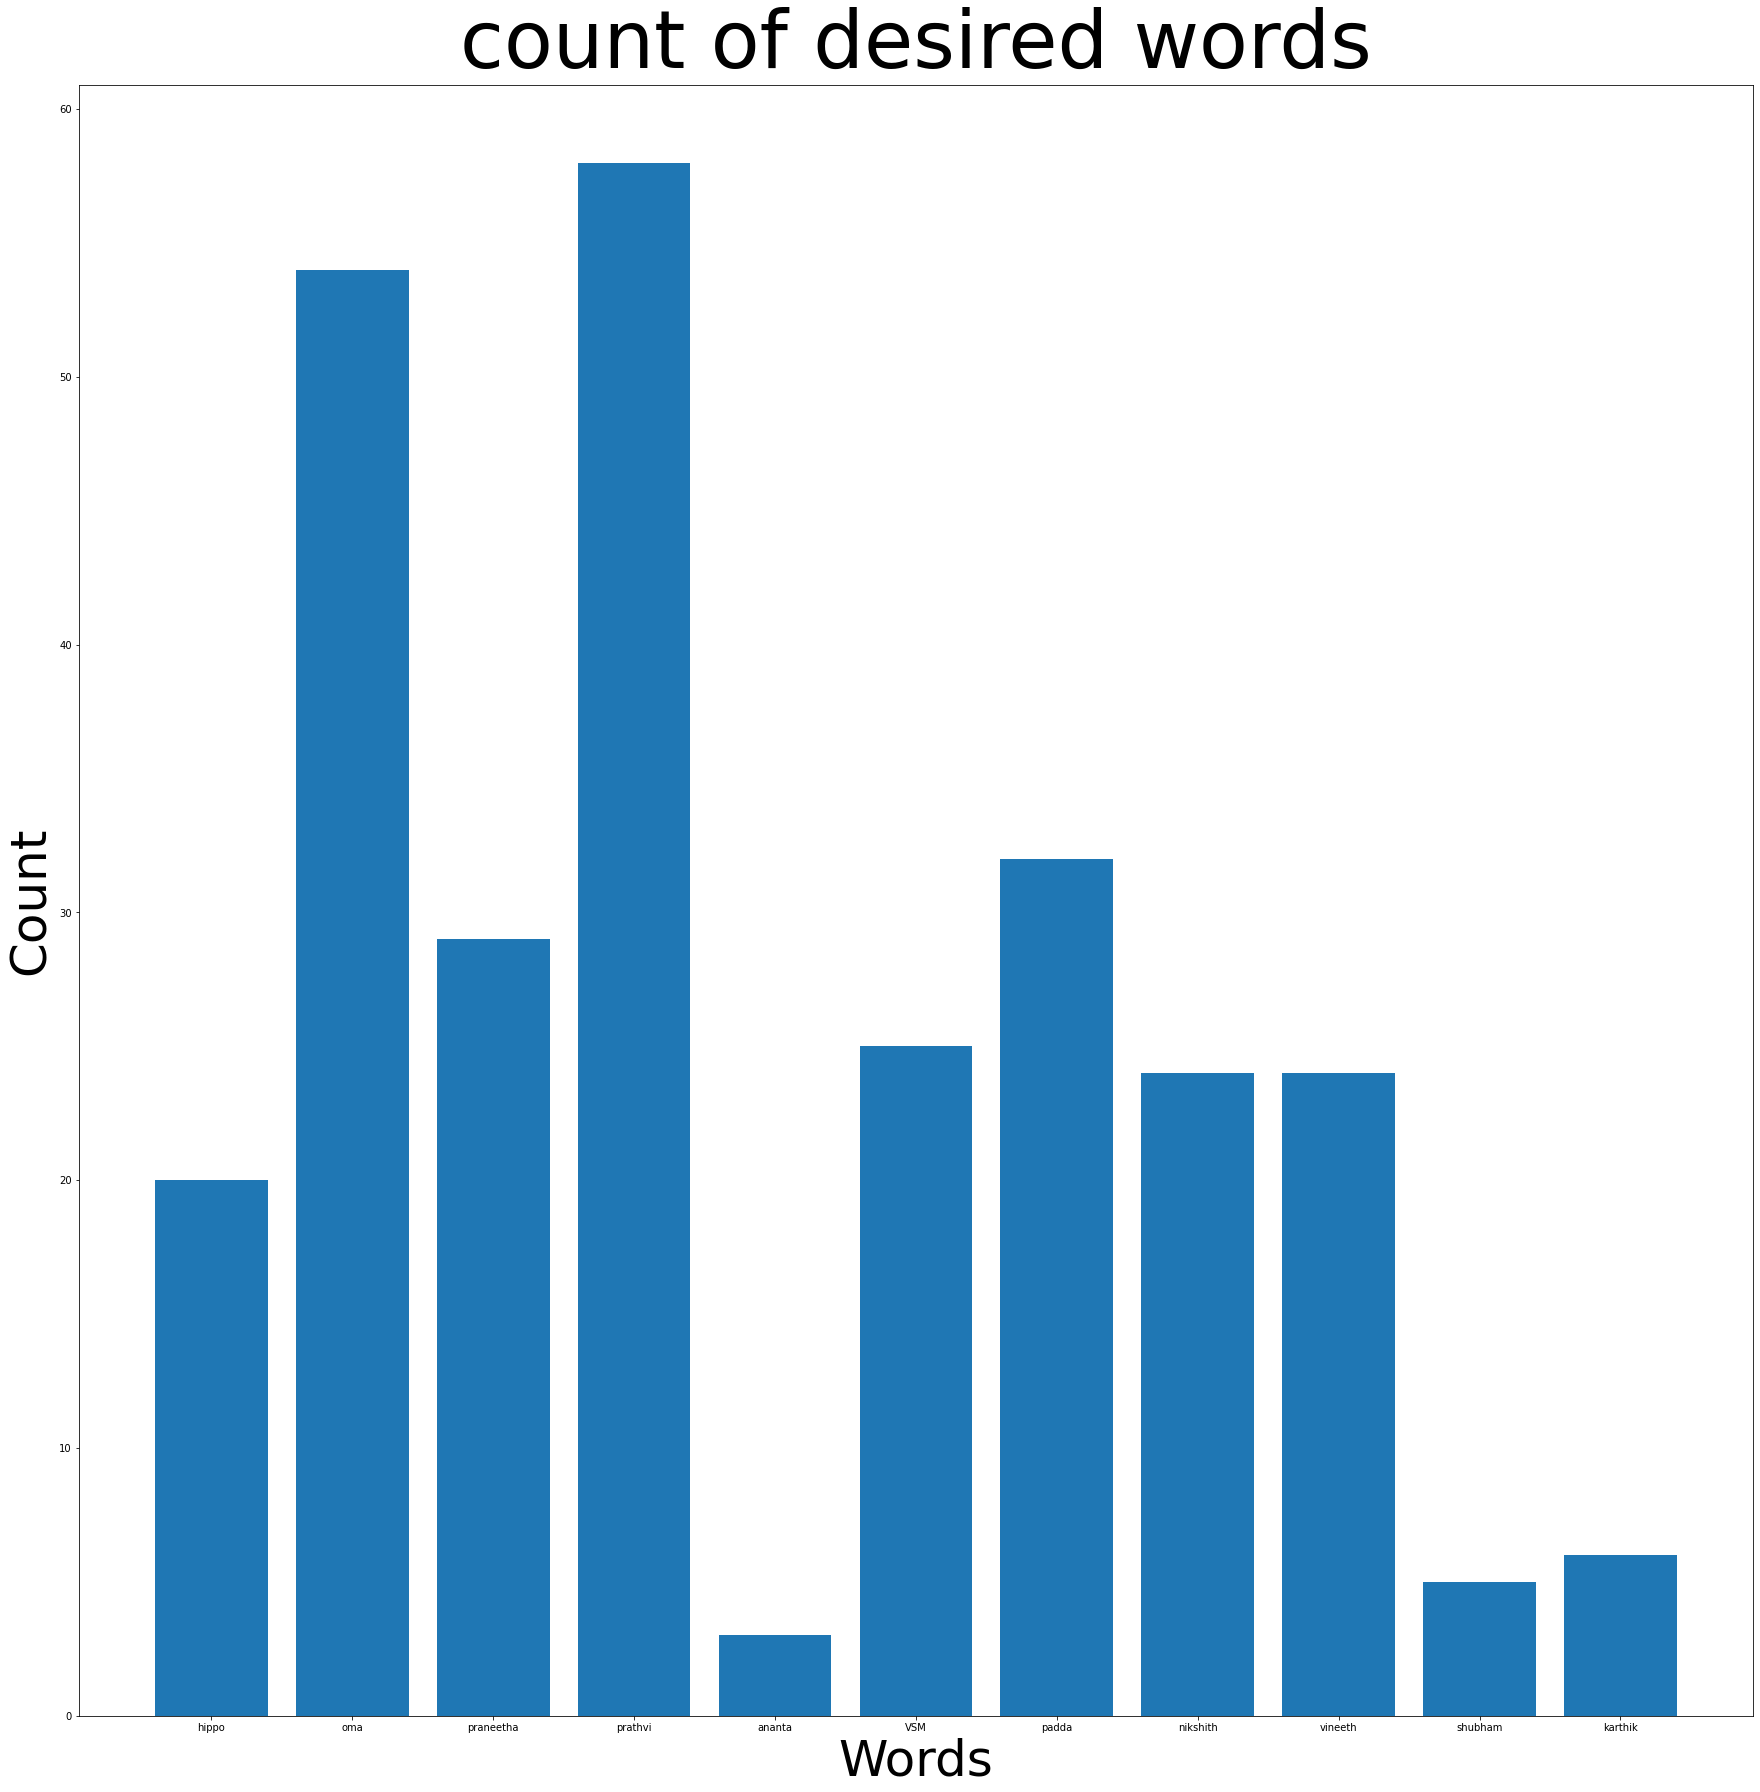

In [20]:
#histogram for count of desired words
plt.figure(figsize=(30,30))
plt.bar(words_x,words_y,align='center') # A bar chart
plt.title('count of desired words',fontsize=80)
plt.xlabel('Words',fontsize=50)
plt.ylabel('Count',fontsize=50)
plt.rcParams["font.size"] = "25"
plt.show()

## Top 10 most used emoji

In [21]:
msgs_word_count_df.sort_values(by=['count'],ascending=False).head(10)

,words,count
23922,:),1989
90,😂,840
45,to,808
279,I,800
25,is,767
16,the,731
22,in,535
102,and,503
88,of,475
161,😂😂,390


In [22]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])

In [23]:
emoji_string = extract_emojis(msgs)
emoji_list = []
for emoji in emoji_string:
    emoji_list.append(emoji)
#     print(emoji)
# emoji_list

In [24]:
emoji_occurence_dict = {}

for item in emoji_list:
    if item not in emoji_occurence_dict:
        emoji_occurence_dict[item] = 1
    else:
        emoji_occurence_dict[item] +=1
emoji_occurence_df = pd.DataFrame.from_dict(emoji_occurence_dict.items())
# print(emoji_occurence_dict)
emoji_occurence_df = emoji_occurence_df.rename(columns={0: "emoji", 1: "count"})
emoji_occurence_df

,emoji,count
0,🔥,276
1,🙏,146
2,🏻,528
3,😂,5011
4,💯,78
...,...,...
272,🎵,1
273,💀,1
274,💉,1
275,💸,1


In [25]:
#most used emojis
top_used_emojis_df = emoji_occurence_df.sort_values(by=['count'],ascending=False).head(10)
top_used_emojis_df

,emoji,count
3,😂,5011
10,🦛,4306
65,😀,2870
24,🥳,1597
68,🙂,1195
13,🤣,1113
2,🏻,528
21,♂,289
0,🔥,276
9,🤩,262
